
# Gradient Boosting — Seleção de Analista Financeiro

Notebook educativo do curso **Introdução ao Machine Learning com Python (UNIVALI)**.
Aplicamos **GradientBoostingClassifier** e visualizamos: **resíduos, learning rate, curvas de aprendizado, métricas e importância**.


In [8]:
# Importação das bibliotecas necessárias
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Para dividir os dados em treino e teste
from sklearn.preprocessing import OneHotEncoder      # Para codificar variáveis categóricas
from sklearn.compose import ColumnTransformer       # Para aplicar transformações específicas por coluna
from sklearn.pipeline import Pipeline               # Para criar pipeline de processamento
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, log_loss
from sklearn.tree import DecisionTreeClassifier     # Modelo baseline
from sklearn.ensemble import GradientBoostingClassifier  # Modelo principal

# Configurações de visualização para matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# Carrega o dataset de candidatos
csv_path = r"../Datasets/candidatos_financeiro.csv"
df = pd.read_csv(csv_path)
df.head()  # Mostra as primeiras linhas do dataset

,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata,selecionado
0,5.6,0,Básico,0,Contabilidade,51.0,5860.0,5.0,1,0
1,4.2,1,Básico,0,Engenharia,89.0,6520.0,3.0,0,0
2,5.9,0,Básico,0,Administração,83.0,6270.0,4.0,0,0
3,7.9,1,Básico,1,Engenharia,70.0,5470.0,4.0,1,1
4,4.0,0,Avançado,1,Contabilidade,74.0,4960.0,4.0,1,1


## 1) Baseline: Árvore rasa

Baseline (Árvore rasa): Acc=0.725 | Prec=1.000 | Rec=0.267 | F1=0.421 | ROC-AUC=0.712
Matriz de confusão:
 [[25  0]
 [11  4]]


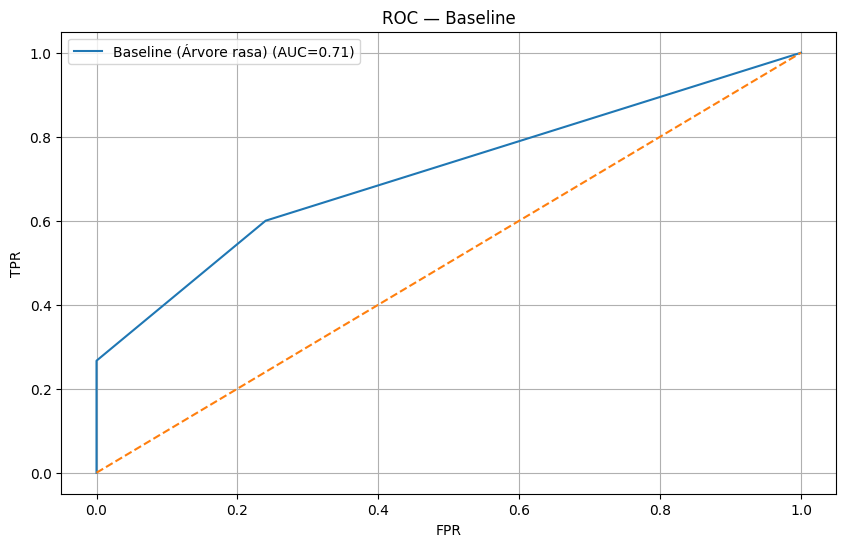

In [9]:
# Separação das features (X) e target (y)
X = df.drop(columns=['selecionado'])  # Remove a coluna target
y = df['selecionado']                 # Define a variável target

# Define as colunas categóricas para one-hot encoding
cat_cols = ['ingles','formacao']
# Cria o preprocessador com OneHotEncoder para variáveis categóricas
pre = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)], remainder='passthrough')

# Divide os dados em treino e teste (75% treino, 25% teste)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Cria e treina o modelo baseline (árvore de decisão simples)
baseline = Pipeline([('pre', pre), ('clf', DecisionTreeClassifier(max_depth=2, random_state=42))])
baseline.fit(X_tr, y_tr)

# Faz predições com o modelo baseline
y_pred_b = baseline.predict(X_te)
y_proba_b = baseline.predict_proba(X_te)[:,1]  # Probabilidades da classe positiva [:,1] todas as linhas sem pegar a coluna 0

# Função para avaliar e reportar métricas do modelo
def eval_report(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"{name}: Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
    print("Matriz de confusão:\n", confusion_matrix(y_true, y_pred))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

# Plota a curva ROC do modelo baseline
plt.figure()
eval_report("Baseline (Árvore rasa)", y_te, y_pred_b, y_proba_b)
plt.plot([0,1],[0,1],'--')  # Linha de referência (random classifier)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Baseline"); plt.legend(); plt.show()

## 2) Gradient Boosting

Gradient Boosting: Acc=0.775 | Prec=0.714 | Rec=0.667 | F1=0.690 | ROC-AUC=0.888
Matriz de confusão:
 [[21  4]
 [ 5 10]]
Baseline (Árvore rasa): Acc=0.725 | Prec=1.000 | Rec=0.267 | F1=0.421 | ROC-AUC=0.712
Matriz de confusão:
 [[25  0]
 [11  4]]


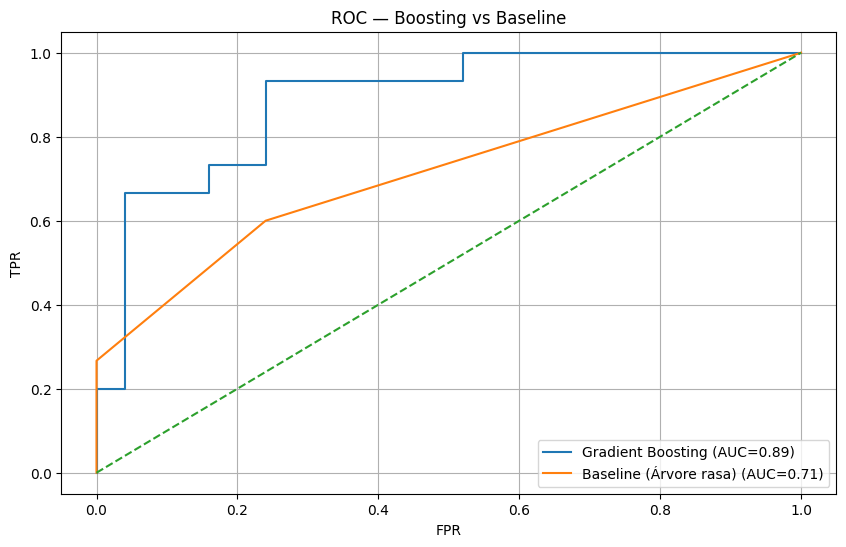

In [10]:
# Cria o pipeline do Gradient Boosting com preprocessamento
gb = Pipeline([
    ('pre', pre),  # Mesmo preprocessador usado no baseline
    ('clf', GradientBoostingClassifier(learning_rate=0.1, n_estimators=35, max_depth=3, random_state=42))  # Parâmetros otimizados
])
gb.fit(X_tr, y_tr)  # Treina o modelo

# Faz predições com o Gradient Boosting
y_pred_gb = gb.predict(X_te)  # Predições das classes
y_proba_gb = gb.predict_proba(X_te)[:,1]  # Probabilidades da classe positiva

# Plota comparação das curvas ROC
plt.figure()
eval_report("Gradient Boosting", y_te, y_pred_gb, y_proba_gb)  # Avalia Gradient Boosting
eval_report("Baseline (Árvore rasa)", y_te, y_pred_b, y_proba_b)  # Compara com baseline
plt.plot([0,1],[0,1],'--') # em x de 0 a 1 e em y de 0 a 1 # Linha de referência (random classifier)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC — Boosting vs Baseline")
plt.legend()
plt.show()

## 3) Curva de aprendizado (log-loss por iteração) Definir qual numero de estimators necessario.

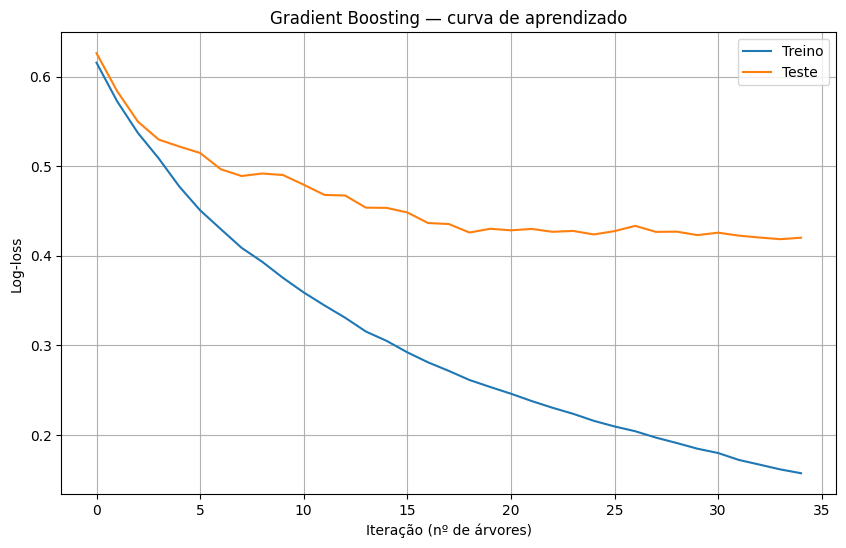

In [11]:
# Acessa o classificador Gradient Boosting do pipeline
clf_gb = gb.named_steps['clf'] 

# Prepara os dados transformados para análise staged_predict_proba
Xtr_enc = pre.fit_transform(X_tr, y_tr)  # Transforma dados de treino (com fit), pois é necessário para o OneHotEncoder (Nosso encondador)
Xte_enc = pre.transform(X_te)  # Transforma dados de teste (sem fit), pois já foi ajustado no treino (Nosso dado ja encondado com base no treino)

# Calcula log-loss para cada iteração do boosting
train_losses, test_losses = [], []
for y_proba_tr in clf_gb.staged_predict_proba(Xtr_enc):  # Avalia em dados de treino
    train_losses.append(log_loss(y_tr, y_proba_tr[:,1])) #log_loss calcula a perda logarítmica do modelo
for y_proba_t in clf_gb.staged_predict_proba(Xte_enc):   # Avalia em dados de teste
    test_losses.append(log_loss(y_te, y_proba_t[:,1]))

# Plota a curva de aprendizado
plt.plot(train_losses, label='Treino')  # Log-loss no treino
plt.plot(test_losses, label='Teste')    # Log-loss no teste
plt.xlabel("Iteração (nº de árvores)"); plt.ylabel("Log-loss"); plt.title("Gradient Boosting — curva de aprendizado")
plt.legend(); plt.show()

## 4) Efeito do Learning Rate (η)

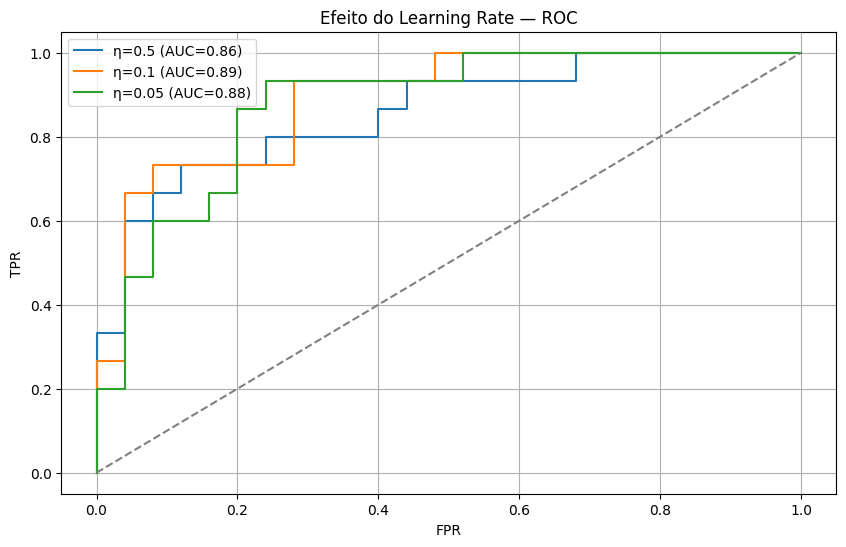

In [12]:
# Lista de learning rates para testar
etas = [0.5, 0.1, 0.05]  # Diferentes valores de eta (learning rate)

# Treina e avalia modelos com diferentes learning rates
for eta in etas:
    # Cria e treina modelo com learning rate específico
    model = Pipeline([('pre', pre), ('clf', GradientBoostingClassifier(learning_rate=eta, n_estimators=45, max_depth=3, random_state=42))])
    model.fit(X_tr, y_tr)
    
    # Calcula probabilidades e curva ROC
    proba = model.predict_proba(X_te)[:,1]  # Probabilidades da classe positiva
    fpr, tpr, _ = roc_curve(y_te, proba)    # Calcula pontos da curva ROC
    roc_auc = auc(fpr, tpr)                 # Calcula área sob a curva
    plt.plot(fpr, tpr, label=f"η={eta} (AUC={roc_auc:.2f})")

# Finaliza o gráfico
plt.plot([0,1],[0,1],'--', color='gray')  # Linha de referência
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Efeito do Learning Rate — ROC")
plt.legend(); plt.show()

## 5) Importância das variáveis (MDI)

excel_avancado              0.195922
ingles_Avançado             0.160095
experiencia_anos            0.158063
raciocinio_logico           0.157524
certificacao_financeira     0.146982
salario_pretendido          0.095621
comunicacao                 0.037745
ingles_Intermediário        0.012751
formacao_Engenharia         0.011078
disponibilidade_imediata    0.010618
formacao_Contabilidade      0.007767
formacao_Economia           0.005833
formacao_Administração      0.000000
ingles_Básico               0.000000
dtype: float64

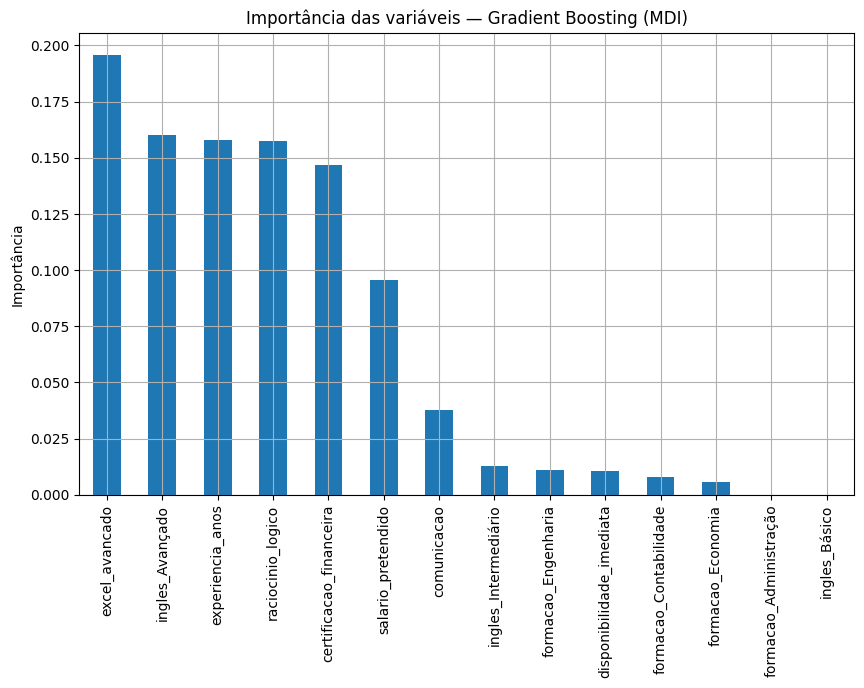

In [13]:
# Extrai o OneHotEncoder do pipeline
oh = gb.named_steps['pre'].named_transformers_['onehot']

# Obtém nomes das features após one-hot encoding
oh_feats = list(oh.get_feature_names_out(['ingles','formacao']))  # Features categóricas codificadas
num_feats = [c for c in X.columns if c not in ['ingles','formacao']]  # Features numéricas
feature_names = oh_feats + num_feats  # Combina todas as features

# Calcula e ordena importância das features
importances = pd.Series(clf_gb.feature_importances_, index=feature_names).sort_values(ascending=False)
display(importances.head(15))  # Mostra top 15 features mais importantes

# Plota gráfico de barras das importâncias
importances.head(15).plot(kind='bar')  # Visualiza top 15 features
plt.title("Importância das variáveis — Gradient Boosting (MDI)"); plt.ylabel("Importância"); plt.show()

In [14]:
# Exemplo de novo candidato para predição
candidate_full = {
    "experiencia_anos": 4,
    "certificacao_financeira": 1,
    "ingles": "Intermediário",
    "excel_avancado": 0,
    "formacao": "Contabilidade",
    "raciocinio_logico": 8.0,
    "salario_pretendido": 4500.0,
    "comunicacao": 7.5,
    "disponibilidade_imediata": 0
}

novo_candidato = pd.DataFrame([candidate_full])

print("=== Perfil do Candidato ===")
display(novo_candidato)

prob = gb.predict_proba(novo_candidato)[0, 1]
pred = gb.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado: {prob:.2%}")
print("Predição final:", "Selecionado" if pred==1 else "Não Selecionado")

=== Perfil do Candidato ===


,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata
0,4,1,Intermediário,0,Contabilidade,8.0,4500.0,7.5,0


Probabilidade de ser selecionado: 11.11%
Predição final: Não Selecionado
